
# Neighborhood Components Analysis


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import seaborn
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from lifelines import CoxPHFitter

In [2]:
clin_file = 'clinical_final_extra.csv'
clin_data = pd.read_csv(clin_file)
clin_data.set_index('bcr_patient_barcode',inplace=True)
clin_data.sort_values(by=["bcr_patient_barcode"]);
# X = X.transpose()

In [3]:
mirna_file = 'mirna_final.csv'
mirna_data = pd.read_csv(mirna_file)
mirna_data.set_index('HYBRIDIZATION R',inplace=True)
mirna_data.sort_values(by=["HYBRIDIZATION R"]);

In [4]:
ll = list(mirna_data.index)
for item in ll:
    tc = item[-3:]
    if tc=="-02":
        mirna_data = mirna_data.drop(str(item))

In [5]:
mirna_data.shape

(512, 548)

In [6]:
lll = list(mirna_data.index)
ll_new = []
for item in lll:
    item = item[0:12]
    ll_new.append(item)
mirna_data.index = ll_new

In [7]:
rem_row = list(set(mirna_data.index)^set(clin_data.index))
rem_row

['TCGA-DU-7011',
 'TCGA-DU-7019',
 'TCGA-QH-A6CW',
 'TCGA-DB-A75M',
 'TCGA-R8-A6YH',
 'TCGA-CS-5390',
 'TCGA-HT-A74J']

In [8]:
for x in rem_row:
    if (x in clin_data.index):
        clin_data = clin_data.drop(x)
    if (x in mirna_data.index):
        mirna_data = mirna_data.drop(x)

print(clin_data.shape)
print(mirna_data.shape)

(509, 32)
(509, 548)


In [9]:
# clin_data.to_csv("processed_clinical_mirna.csv")
# mirna_data.to_csv("processed_mirna.csv")

In [27]:
clin_data.corr(method="spearman")

,age_at_initial_pathologic_diagnosis,initial_pathologic_dx_year,birth_days_to,last_contact_days_to,death_days_to,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Grade
age_at_initial_pathologic_diagnosis,1.000000,0.006285,-0.999710,-0.041717,-0.572767,NaN,NaN,NaN,-0.261601,NaN,NaN,0.201026,-0.147350,0.198300,-0.147350,0.055754,-0.140488,0.146056,-0.123711,0.206247
initial_pathologic_dx_year,0.006285,1.000000,-0.006991,-0.496989,-0.353454,NaN,NaN,NaN,-0.302912,NaN,NaN,-0.454344,-0.463743,-0.437442,-0.463743,-0.029852,-0.573850,-0.364675,-0.293374,-0.016672
birth_days_to,-0.999710,-0.006991,1.000000,0.042610,0.569919,NaN,NaN,NaN,0.259830,NaN,NaN,-0.202110,0.147854,-0.199261,0.147854,-0.052678,0.139281,-0.147502,0.124591,-0.207083
last_contact_days_to,-0.041717,-0.496989,0.042610,1.000000,NaN,NaN,NaN,NaN,0.618066,NaN,NaN,0.076154,1.000000,0.076154,1.000000,0.182936,0.955158,0.279795,0.897843,-0.092196
death_days_to,-0.572767,-0.353454,0.569919,NaN,1.000000,NaN,NaN,NaN,0.775190,NaN,NaN,NaN,1.000000,-0.026808,1.000000,0.130931,0.485714,-0.055143,0.779670,-0.329581
new_tumor_event_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_tumor_event_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_tumor_event_site_other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_tumor_event_dx_days_to,-0.261601,-0.302912,0.259830,0.618066,0.775190,NaN,NaN,NaN,1.000000,NaN,NaN,-0.039441,0.715599,-0.045051,0.715599,NaN,1.000000,NaN,1.000000,-0.245067
margin_status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# X = mirna_data.loc[:,["hsa-let-7e","hsa-let-7f-2","hsa-mir-10b","hsa-mir-1275","hsa-mir-1304","hsa-mir-143","hsa-mir-155","hsa-mir-301b","hsa-mir-3074","hsa-mir-3136","hsa-mir-3158-2","hsa-mir-320a","hsa-mir-3622b","hsa-mir-3678","hsa-mir-3690","hsa-mir-3923"]]
X=StandardScaler().fit(mirna_data).transform(mirna_data)

In [74]:
pd.DataFrame(X).dropna().shape

(509, 550)

In [68]:
y = clin_data[["OS","OS.time"]]
data=pd.DataFrame(X).dropna()
data["Survival"] = y["OS.time"]
data["Censor"] = y["OS"]

In [70]:
cph = CoxPHFitter(penalizer=10)
cph.fit(data, duration_col='Survival', event_col='Censor', show_progress=True, step_size=0.2)
cph.print_summary()

TypeError: NaNs were detected in the dataset. Try using pd.isnull to find the problematic values.

In [46]:
cph.predict_cumulative_hazard(X)

,TCGA-CS-4938,TCGA-CS-4941,TCGA-CS-4942,TCGA-CS-4943,TCGA-CS-4944,TCGA-CS-5393,TCGA-CS-5394,TCGA-CS-5395,TCGA-CS-5396,TCGA-CS-5397,...,TCGA-VW-A8FI,TCGA-W9-A837,TCGA-WH-A86K,TCGA-WY-A858,TCGA-WY-A859,TCGA-WY-A85A,TCGA-WY-A85B,TCGA-WY-A85C,TCGA-WY-A85D,TCGA-WY-A85E
T,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752.0,0.067667,108859.110850,32.963304,124.415616,9.722386,7.257482,2.571829,1425.504346,2.191823,270942.917864,...,46459.595086,8.325758,0.872419,1.120771,4.018931,3.384218,1.759676,3.156666,23.572126,374.056645
5166.0,0.090701,145913.542904,44.183646,166.765309,13.031778,9.727848,3.447252,1910.730190,2.937895,363168.877290,...,62273.925149,11.159754,1.169380,1.502269,5.386930,4.536168,2.358650,4.231160,31.595816,501.381372
5255.0,0.090701,145913.542904,44.183646,166.765309,13.031778,9.727848,3.447252,1910.730190,2.937895,363168.877290,...,62273.925149,11.159754,1.169380,1.502269,5.386930,4.536168,2.358650,4.231160,31.595816,501.381372


In [22]:
pd.DataFrame(list(logreg.coef_)).to_csv("hi.csv")

In [13]:
random_state=0
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit(X).fit_transform(X))

In [14]:
data_frame = X
data_frame["y"] = y_new
data_frame=shuffle(data_frame)

In [ ]:
# accuracies_test_list = pd.DataFrame(index=pd.Series(range(2,X_train.shape[0])), columns = pd.Series(range(1,X_train.shape[1])))
# accuracies_train_list = pd.DataFrame(index=pd.Series(range(2,X_train.shape[0])), columns = pd.Series(range(1,X_train.shape[1])))
# for i in tqdm(range(2,X_train.shape[0])):
#     for j in range(1,X_train.shape[1]):
#         n_neighbors = i
#         random_state = 0
#         nca = make_pipeline(StandardScaler(),NeighborhoodComponentsAnalysis(n_components=j,random_state=random_state))
#         # Fit the model
#         nca.fit(X_train, y_train)
#         # Fit a nearest neighbor classifier on the embedded training set
#         knn = KNeighborsClassifier(n_neighbors=n_neighbors)
#         knn.fit(nca.transform(X_train), y_train)
#         # Compute the nearest neighbor accuracy on the embedded test set
#         acc_knn_test = knn.score(nca.transform(X_test), y_test)
#         acc_knn_train = knn.score(nca.transform(X_train), y_train)
#         accuracies_test_list.iloc[i-2,j-1] = acc_knn_test
#         accuracies_train_list.iloc[i-2,j-1] = acc_knn_train

In [ ]:
# j=1
# X_test = data_frame.iloc[int(j*510/5):int((j+1)*510/5),:].drop("y", axis=1)
# y_test = data_frame.iloc[int(j*510/5):int((j+1)*510/5),data_frame.shape[1]-1]
# X_train = data_frame.drop(data_frame.index[range(int(j*510/5),int((j+1)*510/5))], axis=0).drop("y", axis=1)
# y_train = data_frame.drop(data_frame.index[range(int(j*510/5),int((j+1)*510/5))], axis=0).loc[:,"y"]

In [15]:
accuracies_test_list = []
accuracies_train_list = []
for i in tqdm(range(2,35)):
    random_state = 0
    nca = make_pipeline(StandardScaler(),NeighborhoodComponentsAnalysis(n_components=16,random_state=3120))
    # Fit the model
    score_te=[]
    score_tr=[]
    for j in range(0,5):
        X_test = data_frame.iloc[int(j*len(y_new)/5):int((j+1)*len(y_new)/5),:].drop("y", axis=1)
        y_test = data_frame.iloc[int(j*len(y_new)/5):int((j+1)*len(y_new)/5),data_frame.shape[1]-1]
        X_train = data_frame.drop(data_frame.index[range(int(j*len(y_new)/5),int((j+1)*len(y_new)/5))], axis=0).drop("y", axis=1)
        y_train = data_frame.drop(data_frame.index[range(int(j*len(y_new)/5),int((j+1)*len(y_new)/5))], axis=0).loc[:,"y"]
        nca.fit(X_train, y_train)
        # Fit a nearest neighbor classifier on the embedded training set
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(nca.transform(X_train), y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn_test = knn.score(nca.transform(X_test), y_test)
        acc_knn_train = knn.score(nca.transform(X_train), y_train)
        score_te.append(acc_knn_test)
        score_tr.append(acc_knn_train)
    accuracies_test_list.append(np.mean(score_te))
    accuracies_train_list.append(np.mean(score_tr))

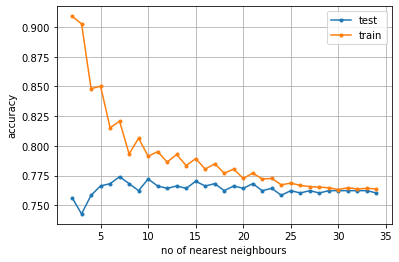

In [16]:
plt.plot(range(2,35),accuracies_test_list, '.-' ,label="test")
plt.plot(range(2,35),accuracies_train_list, '.-' , label="train")
plt.legend()
plt.xlabel("no of nearest neighbours")
plt.ylabel("accuracy")
plt.grid()

In [17]:
opt_nn = np.argmax(accuracies_test_list)+2
print(opt_nn)

7


In [18]:
max_acc = accuracies_test_list[np.argmax(accuracies_test_list)]
print(max_acc)

0.7740827023878859


In [21]:
#grid search
accuracies_test_list = pd.DataFrame(index=pd.Series(range(2,20)), columns = pd.Series(range(2,20)))
accuracies_train_list = pd.DataFrame(index=pd.Series(range(2,20)), columns = pd.Series(range(2,20)))
for i in tqdm(range(2,20)):
    random_state = 0
    nca = make_pipeline(StandardScaler(),NeighborhoodComponentsAnalysis(n_components=i,random_state=3120))
    # Fit the model
    for k in range(2,20):
        score_te=[]
        score_tr=[]
        for j in range(0,5):
            X_test = data_frame.iloc[int(j*len(y_new)/5):int((j+1)*len(y_new)/5),:].drop("y", axis=1)
            y_test = data_frame.iloc[int(j*len(y_new)/5):int((j+1)*len(y_new)/5),data_frame.shape[1]-1]
            X_train = data_frame.drop(data_frame.index[range(int(j*len(y_new)/5),int((j+1)*len(y_new)/5))], axis=0).drop("y", axis=1)
            y_train = data_frame.drop(data_frame.index[range(int(j*len(y_new)/5),int((j+1)*len(y_new)/5))], axis=0).loc[:,"y"]
            nca.fit(X_train, y_train)
            # Fit a nearest neighbor classifier on the embedded training set
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(nca.transform(X_train), y_train)
            # Compute the nearest neighbor accuracy on the embedded test set
            acc_knn_test = knn.score(nca.transform(X_test), y_test)
            acc_knn_train = knn.score(nca.transform(X_train), y_train)
            score_te.append(acc_knn_test)
            score_tr.append(acc_knn_train)
        accuracies_test_list.iloc[i-2,k-2] = np.mean(score_te)
        accuracies_train_list.iloc[i-2,k-2] = np.mean(score_tr)

Text(0, 0.5, 'n_neighbours')

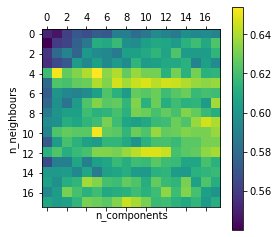

In [36]:
plt.matshow(accuracies_test_list.values.astype(np.float32))
plt.colorbar()
plt.xlabel("n_components")
plt.ylabel("n_neighbours")

AttributeError: 'AxesImage' object has no property 'type'

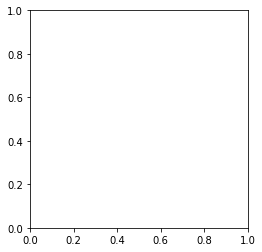

In [25]:
plt.imshow(np.array(accuracies_train_list),type="float")

In [ ]:
X = data_frame.drop("y", axis=1)
y = data_frame.iloc[:,data_frame.shape[1]-1]
nca.fit(X, y)
# Fit a nearest neighbor classifier on the embedded training set
knn = KNeighborsClassifier(n_neighbors=opt_nn)
knn.fit(nca.transform(X), y)
# Compute the nearest neighbor accuracy on the embedded test set
acc_knn = knn.score(nca.transform(X), y)

In [ ]:
#comparing with matlab version - knn


In [ ]:
# accuracies_test_list = accuracies_test_list[accuracies_test_list.columns].astype(float)
# n_s=accuracies_test_list.iloc[:120,:]
# seaborn.heatmap(np.array(accuracies_test_list))
plt.plot(accuracies_test_list)

In [ ]:
accuracies_test_list.max()

In [ ]:
plt.plot(accuracies_test_list.max())
plt.xlabel("Number of components")
plt.ylabel("Max test accuracy")

In [ ]:
plt.plot(accuracies_test_list.max(axis=1))
plt.xlabel("Number of neighbours")
plt.ylabel("Max test accuracy")

In [ ]:
plt.plot(accuracies_test_list.iloc[:100,7], label="Test")
plt.plot(accuracies_train_list.iloc[:100,7], label="Train")
plt.legend()

In [ ]:
#find best component
te_max=list(accuracies_test_list.max())
opt_n_comp=te_max.index(max(te_max))+1

In [ ]:
#find best neighbour
te_max_opt=list(accuracies_test_list.iloc[:,opt_n_comp-1])
opt_n_nbr = te_max_opt.index(max(te_max_opt))+2

In [ ]:
n_neighbors = opt_n_nbr
random_state = 0
nca = make_pipeline(StandardScaler(),NeighborhoodComponentsAnalysis(n_components=opt_n_comp,random_state=random_state))
cv_test=[]
cv_train=[]
for i in tqdm(range(0,10)):
    X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.4, stratify=y_new)
    # Fit the model
    nca.fit(X_train, y_train)
    # Fit a nearest neighbor classifier on the embedded training set
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(nca.transform(X_train), y_train)
    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn_test = knn.score(nca.transform(X_test), y_test)
    acc_knn_train = knn.score(nca.transform(X_train), y_train)
    cv_test.append(acc_knn_test)
    cv_train.append(acc_knn_train)
    print(acc_knn_test,acc_knn_train)
print("CV errors: ",np.mean(cv_test),np.mean(cv_train))

In [ ]:
print(accuracies_test_list[np.argmax(accuracies_test_list)])
print(accuracies_train_list[np.argmin(accuracies_train_list)])
plt.plot(accuracies_test_list, label="test")
plt.plot(accuracies_train_list, label="train")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter(X_embedded[:,4],X_embedded[:,8], c=y_new)
cbar=plt.colorbar(pnt3d)
cbar.set_label("Values (units)")

In [ ]:
kmeans=[]
g = X.transpose()
for i in tqdm(range(2,20)):
    temp=KMeans(n_clusters=i, random_state=0).fit(g)
    kmeans.append(temp.score(g))

In [ ]:
plt.plot(range(2,20),kmeans,".-")

In [ ]:
gg = KMeans(n_clusters=5, random_state=0).fit(g)
# mirna_data.append(gg.labels_)

In [ ]:
mirna_data=mirna_data.append(pd.Series(gg.labels_, index=mirna_data.columns, name = "Group"))

In [ ]:
groups = set(mirna_data.loc["Group",:])

In [ ]:
plt.hist(mirna_data.loc["Group",:])